In [23]:
# auto load all the functions
%load_ext autoreload
%autoreload 2
import pandas as pd
from std import stdsmi # standardize smiles
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read experimental file

In [8]:
df = pd.read_excel('../July_28.xlsx',sheet_name='all',header=1)
df.head()

,Order,Source,ChemicalName,C18RT,PFPRT,INCHIKEY,Short,CanonicalSMILES,Unnamed: 8,pred_C18,error
0,94,analyticon,"3-Hydroxy-12-oleanene-27,28-dioic acid, 3-O-(6...",NaN,4.614,PUOQHFWXBKTHST-UHFFFAOYSA-N,PUOQHFWXBKTHST,CC1CCC2(CCC3(C(=CCC4C3(CCC5C4(CCC(C5(C)C)OC6C(...,NaN,5.833116,NaN
1,95,analyticon,"NCGC00169815-02_C36H56O9_Urs-12-ene-27,28-dioi...",5.183,4.683,PUOQHFWXBKTHST-UHFFFAOYSA-N,PUOQHFWXBKTHST,CC1CCC2(CCC3(C(=CCC4C3(CCC5C4(CCC(C5(C)C)OC6C(...,NaN,5.833116,0.650116
2,144,analyticon,"3-Hydroxy-6-[(3-hydroxy-2,4-dimethylhept-4-eno...",3.950,3.446,JNKVBUQSDAHKDQ-VQHVLOKHSA-N,JNKVBUQSDAHKDQ,CCC=C(C)C(C(C)C(=O)NCC(=O)C(C)C(C(C)C(=O)O)O)O,NaN,3.705359,0.244641
3,156,analyticon,"[(2R,3S,4S,5R,6S)-3,4,5-trihydroxy-6-[2-hydrox...",3.950,3.700,ZOEFIRUNMVHSJA-XXZDZOCTSA-N,ZOEFIRUNMVHSJA,CC(=CC1(C(C(C(=O)C(C1=O)(C)C)(C)C)OC2C(C(C(C(O...,NaN,3.998025,0.048025
4,266,analyticon,Diosmin; Barosmin; Daflon,3.300,3.300,GZSOSUNBTXMUFQ-YFAPSIMESA-N,GZSOSUNBTXMUFQ,CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=CC(=C4C(=C3)O...,NaN,3.331451,0.031451


## SMILES standardization

In [ ]:
# clean dimolecules, neutralisation, desalt, standardize smiles
df['CanonicalSMILES'] = df['CanonicalSMILES'].apply(stdsmi)
# remove null smiles and wrong smiles
df = df.dropna(subset=['CanonicalSMILES'])

## Experimental data quality control

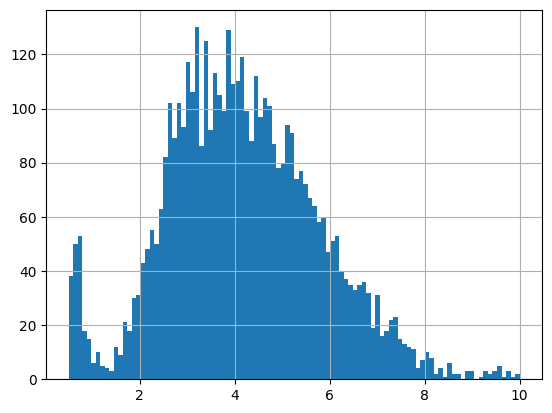

In [15]:
# Use C18 column as an example
clean = df[df['C18RT'].notnull()]
# remove outliers by plotting the histogram
clean['C18RT'].hist(bins=100)
# remove outliers by setting the range
clean = clean[(clean['C18RT'] > 0) & (clean['C18RT'] < 10)]
# get average retention time for duplicates
# clean = clean.groupby('CanonicalSMILES')['C18RT'].mean().reset_index()
# save the cleaned data
# clean.to_csv('C18_clean.csv',index=False)

### From quality control comounds, the intrinsic error is around x min for C18 column

In [ ]:
# get inchikeys from smiles

clean['InChIKey'] = clean['CanonicalSMILES'].apply(smiles_to_inchikey)

Mean difference in C18: 0.19632142857142854


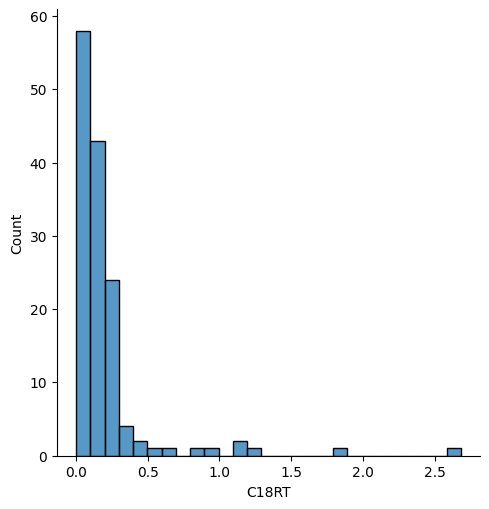

In [28]:
# Filter and calculate retention time differences for duplicate compounds

results, mean_diff = calculate_retention_time_difference(clean, column='C18RT')
print(f"Mean difference in C18: {mean_diff}")

## Get classifications

In [ ]:
SERVER_URL = "http://192.168.0.2:1234/"
smiles_list = clean["CanonicalSMILES"].to_list()
responses = query(smiles_list, SERVER_URL)

In [ ]:
# convert results to df
C = []
pathway = []
SC = []
glyco = []
i=0
for r in responses:
    try:
        test = r.json() 
    except:
        C.append('NA')              
        pathway.append('NA')
        SC.append('NA')
        glyco.append('NA')
        continue
    C.append(test['class_results'])              
    pathway.append(test['pathway_results'])
    SC.append(test['superclass_results'])
    glyco.append(test['isglycoside'])
    i += 1
    
df = pd.DataFrame({'SMILES':smiles_list,'pathway_results':pathway, 'superclass_results':SC, 'class_results':C, 'isglycoside':glyco })
df['class_results'] = df['class_results'].apply(lambda x: ''.join(x))
df['pathway_results'] = df['pathway_results'].apply(lambda x: ''.join(x))
df['superclass_results'] = df['superclass_results'].apply(lambda x: ''.join(x))
df.to_csv('C18_classfication.csv',index=False)

In [ ]:
# plot 
sns.histplot(data=df, x="pathway_results")